In [182]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import random
from collections import Counter
import time

In [183]:
#chargement de données et interpreté comme matrice de proba
matrice_proba = np.loadtxt('transitions_alphabets.txt')

In [184]:
# Charger le message à chiffré
#with open('MSG.txt', 'r') as f:
#    message = list(f.read().strip().upper())  # Lis le message, supprime les espaces inutiles et convertit en majuscules

#print("Message à déchiffrer est", message)

In [185]:
# Construire l'alphabet avec l'espace comme premier caractère
alphabet = [' '] + [chr(i) for i in range(ord('A'), ord('Z') + 1)]

print("Alphabet --->", alphabet)


Alphabet ---> [' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [186]:
#verification 
np.shape(matrice_proba)

(27, 27)

In [187]:
#verification
print(matrice_proba)

[[0.00000000e+00 9.09075846e-02 1.48907496e-02 7.03168151e-02
  1.16115812e-01 9.71046992e-02 2.63294523e-02 9.97503480e-03
  7.25206018e-03 3.42829684e-02 2.08724565e-02 4.97094757e-05
  9.04933389e-02 5.34542562e-02 2.92346950e-02 2.15407728e-02
  8.13744118e-02 5.32222787e-02 2.69204427e-02 6.96982082e-02
  2.81742262e-02 2.65890462e-02 2.69977686e-02 6.07560259e-05
  1.10465502e-04 3.88838566e-03 1.43605152e-04]
 [1.55572450e-01 1.46200968e-05 1.57750844e-02 2.29096917e-02
  8.07029343e-03 1.75441161e-04 2.35383558e-03 1.78218980e-02
  1.65207094e-03 2.61348850e-01 1.69593123e-03 1.46200968e-05
  3.35531221e-02 2.45471425e-02 1.46654191e-01 3.07022032e-04
  1.98540914e-02 3.88894574e-03 7.20770772e-02 4.48252167e-02
  3.29390781e-02 6.50594307e-02 6.22523721e-02 0.00000000e+00
  1.02340677e-04 6.12582055e-03 4.09362710e-04]
 [1.93143409e-03 8.32126187e-02 8.04764204e-04 0.00000000e+00
  1.28762273e-03 1.51939482e-01 0.00000000e+00 0.00000000e+00
  1.60952841e-04 1.69805247e-01 8.69

In [188]:
def dechiffrer_message_dict(message_code, alphabet, permutation_alphabet):
    """
    Déchiffre un message en utilisant un dictionnaire basé sur une permutation de l'alphabet.
    
    Args:
        message_code (list): Message codé sous forme de liste de caractères.
        alphabet (list): Alphabet d'origine (par exemple, [' ', 'A', ..., 'Z']).
        permutation_alphabet (list): Permutation de l'alphabet pour le déchiffrement.

    Returns:
        list: Message décodé sous forme de liste de caractères.
    """
    # Vérification de la correspondance des tailles
    if len(alphabet) != len(permutation_alphabet):
        raise ValueError("L'alphabet et la permutation doivent avoir la même longueur.")

    # Création du dictionnaire pour la correspondance inverse
    decrypt_dict = {permutation_alphabet[i]: alphabet[i] for i in range(len(alphabet))}
    
    # Décodage du message
    message_dechiffre = [decrypt_dict[char] for char in message_code if char in decrypt_dict]
    return message_dechiffre


In [189]:
def calculer_V(texte, matrice_proba, alphabet, permutation_alphabet):
    """
    Calcule la vraisemblance logarithmique d'un texte en utilisant une matrice de probabilités.
    
    Args:
        texte (list): Message sous forme de liste de caractères.
        matrice_proba : Matrice des probabilités de transition (27x27).
        alphabet (list): Alphabet d'origine (par exemple, [' ', 'A', ..., 'Z']).
        permutation_alphabet (list): Permutation de l'alphabet utilisée pour déchiffrer.

    Returns:
        float: Valeur normalisée de la vraisemblance logarithmique.
    """
    # Déchiffrer le texte
    texte_dechiffre = dechiffrer_message_dict(texte, alphabet, permutation_alphabet)
    
    V = 0  # Initialiser la vraisemblance
    
    # Calcul de la vraisemblance logarithmique
    for i in range(len(texte_dechiffre) - 1):
        c1, c2 = texte_dechiffre[i], texte_dechiffre[i + 1]
        idx1 = 0 if c1 == ' ' else alphabet.index(c1)
        idx2 = 0 if c2 == ' ' else alphabet.index(c2)
        V += np.log(matrice_proba[idx1][idx2] + 1e-15)  # Ajoute d'une petite valeur pour éviter log(0)
    
    # Normalisation par la longueur du texte
    return V / len(texte_dechiffre)


In [190]:
def recuit_simule_decrypt(message_code, matrice_proba, alphabet, max_iter, h):
    npr.seed(1)
    random.seed(1)
    """
    Algorithme de recuit simulé pour déchiffrer un message codé.
    
    Args:
        message_code (list): Message codé sous forme de liste de caractères.
        matrice_proba (numpy.ndarray): Matrice de probabilités de transition.
        alphabet (list): Alphabet d'origine (par exemple, [' ', 'A', ..., 'Z']).
        it (int): Nombre maximal d'itérations.
        h (float): Paramètre de contrôle pour la température.

    Returns:
        list, list: Liste des permutations successives et des valeurs d'énergie associées.
    """
    
    
    # Génération de l'état initial (une permutation de l'alphabet)
    etat0 = random.sample(alphabet, len(alphabet))
    etat = etat0[:] #une copie de etat0
    
    # Stockage des résultats
    val_etat = [etat]  # Liste des permutations successives
    energie_vals = []  # Liste des énergies associées
    
    for i in range(max_iter):
        # Copie de l'état actuel
        etat_avant = etat[:]

        # Génération d'une nouvelle permutation (échange de deux lettres)
        a, b = npr.choice(len(alphabet), 2, replace=False)
        etat[a], etat[b] = etat[b], etat[a]

        # Calcul des énergies (vraisemblance logarithmique)
        energie_etat = calculer_V(message_code, matrice_proba, alphabet, etat)
        energie_etat_avant = calculer_V(message_code, matrice_proba, alphabet, etat_avant)
        energie_vals.append(energie_etat)

        # Calcul de la température
        T = h / np.log(i + 2)

        # Critère d'acceptation
        if npr.rand() < min(1, np.exp((energie_etat - energie_etat_avant) / T)):
            val_etat.append(etat[:])
        else:
            etat = etat_avant[:]

        # Vérification si le potentiel dépasse un seuil pour arrêter prématurément
        if energie_etat >= -2.12:
            print(f"Message décodé en {i+1} itérations.")
            break

    return val_etat, energie_vals


In [191]:
mes = ['F', 'R', 'N', 'B', 'R', 'J', 'M', 'F', 'B', 'R', 'N', 'Q', 'X', 'H', 'F', 'Y', 'N', 'W', 'S', 'R', 'N', 'K', 'R', 'D', 'N', 'Z', 'L', 'X', 'D', 'R', 'D', 'N', 'M', 'O', 'O', 'H', 'C', 'R', 'F', 'Y', 'N', 'Z', 'X', 'J', 'J', 'R', 'N', 'Y', 'S', 'N', 'K', 'R', 'D', 'N', 'B', 'R', 'D', 'H', 'O', 'R', 'D', 'N', 'J', 'M', 'H', 'D', 'N', 'B', 'R', 'D', 'H', 'O', 'R', 'N', 'W', 'S', 'N', 'R', 'K', 'K', 'R', 'D', 'N', 'M', 'O', 'O', 'H', 'C', 'R', 'F', 'Y', 'N', 'Z', 'X', 'J', 'J', 'R', 'N', 'R', 'K', 'K', 'R', 'D', 'N', 'M', 'O', 'O', 'H', 'C', 'R', 'F', 'Y', 'N', 'R', 'Y', 'N', 'Y', 'S', 'N', 'Q', 'O', 'X', 'D', 'Q', 'R', 'O', 'R', 'O', 'M', 'D', 'N', 'Y', 'X', 'S', 'V', 'X', 'S', 'O', 'D', 'N', 'R', 'Q', 'H', 'Z', 'Y', 'R', 'Y', 'R']

In [192]:
# Paramètres d'exécution de l'algorithme
max_iter = 15000  # Nombre d'itérations
h = 0.013  # Température initiale

# Lancer le recuit simulé pour déchiffrer le message
permutations, energie_vals = recuit_simule_decrypt(mes, matrice_proba, alphabet, max_iter, h)


Message décodé en 2148 itérations.


In [ ]:
final_permu = permutations[-1]  # Dernière permutation trouvée
if len(final_permu) != len(alphabet):
    raise ValueError("La permutation finale n'a pas la même longueur que l'alphabet.")

# Calcul et affichage du potentiel du message
potentiel_final = calculer_V(mes, matrice_proba, alphabet, final_permu)
print("Potentiel du message décodé via la dernière permutation est :", potentiel_final)

# Décodage et affichage du message
message_decode = dechiffrer_message_dict(mes, alphabet, final_permu)
print(" Le Message décodé est -->", ''.join(message_decode))


Potentiel du message décodé via la dernière permutation est : -2.0975792909151565
 Le Message décodé est --> NE DEMANDE POINT QUE LES CHOSES ARRIVENT COMME TU LES DESIRES MAIS DESIRE QU ELLES ARRIVENT COMME ELLES ARRIVENT ET TU PROSPERERAS TOUJOURS EPICTETE


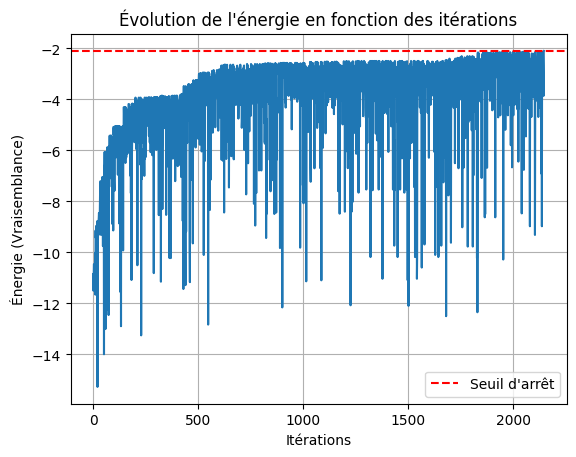

In [194]:
#Evolution du potentiel (energie)
plt.plot(energie_vals)
plt.title("Évolution de l'énergie en fonction des itérations")
plt.axhline(y=-2.12, color='red', linestyle='--', label="Seuil d'arrêt")
plt.xlabel("Itérations")
plt.ylabel("Énergie (Vraisemblance)")
plt.legend()
plt.grid()
plt.show()

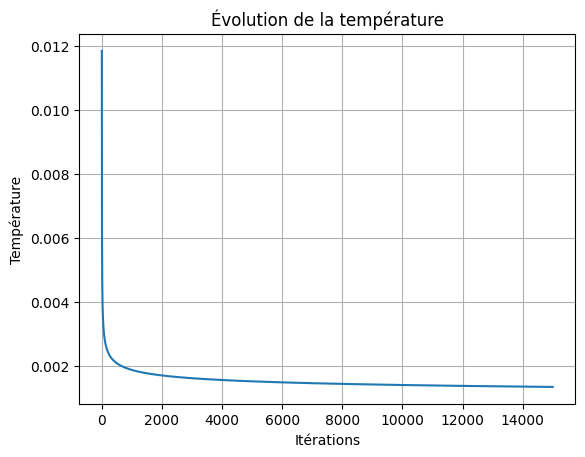

In [195]:
#Evolution de la temperature en fonction des itérations
temperatures = [h / np.log(i + 2) for i in range(1, max_iter + 1)]
plt.plot(range(1, max_iter + 1), temperatures)
plt.title("Évolution de la température")
plt.xlabel("Itérations")
plt.ylabel("Température")
plt.grid()
plt.show()